In [98]:
%load_ext autoreload
%autoreload 2
%aimport mcfost
%matplotlib inline
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterExponent
from numpy import unravel_index
import astropy.units as unit
import pysynphot
import os
import math
from sh import gunzip
from pylab import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [99]:
def bandavg(file_dir):
    px=256
    py=256
    c=2.99792*10**14
    jy=10**26
    psf_scale=0.0208 ##arcsecs/pixel
    xpix=(np.arange ((-px/2)+50, (px/2)-50, 1))*psf_scale
    ypix=(np.arange ((-px/2)+50, (px/2-50), 1))*psf_scale
    sq_as_per_pix=psf_scale**2
    model_in=mcfost.ModelResults(file_dir)
    wav=list(model_in._wavelengths_lookup.values())
    fig_path=file_dir+'band_avg.pdf'
    l=len(wav)
    figr=[]
    sst_band=np.zeros((256,256),dtype=float)
    I_band=np.zeros((256,256),dtype=float)
    Q_band=np.zeros((256,256),dtype=float)
    U_band=np.zeros((256,256),dtype=float)
    for i in range (l):
        im=model_in.images[wav[i]]
        lam=float(wav[i]) #in microns#
        
        I=np.reshape(im.data[0,0],(px,py))
        Q=np.reshape(im.data[1,0],(px,py))
        U=np.reshape(im.data[2,0],(px,py))
        sst=np.reshape(im.data[5,0],(px,py))
        
        sst_jy=(sst/c)*(lam)*jy
        sst_band=sst_band+sst_jy
        
        I_jy=(I/c)*(lam)*jy
        I_band=I_band+I_jy
        
        Q_jy=(Q/c)*(lam)*jy
        Q_band=Q_band+Q_jy
        
        U_jy=(U/c)*(lam)*jy
        U_band=U_band+U_jy
        
    sst_avg=sst_band/l
    I_avg=I_band/l
    Q_avg=Q_band/l
    U_avg=U_band/l
        
    hdu = fits.PrimaryHDU(sst_avg.astype(np.float64))
    hdul = fits.HDUList([hdu])
    hdul.writeto(file_dir+'sst_band.fits',overwrite=True)
    hdu = fits.PrimaryHDU(I_avg.astype(np.float64))
    hdul = fits.HDUList([hdu])
    hdul.writeto(file_dir+'I_band.fits',overwrite=True)
    hdu = fits.PrimaryHDU(Q_avg.astype(np.float64))
    hdul = fits.HDUList([hdu])
    hdul.writeto(file_dir+'Q_band.fits',overwrite=True)
    hdu = fits.PrimaryHDU(U_avg.astype(np.float64))
    hdul = fits.HDUList([hdu])
    hdul.writeto(file_dir+'U_band.fits',overwrite=True)
        
    fig = plt.figure(figsize=(25, 10))
    ax1=fig.add_subplot(141)
    ax1.yaxis.set_ticks_position('both')
    ax1.xaxis.set_ticks_position('both')
    ax1.minorticks_on()
    ax1.tick_params(which='both', direction='in', width=0.5, labelsize=16)
    im1=ax1.imshow(I_avg.astype(np.float64)[78:178,78:178],cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
    ax1.invert_yaxis()
    ax1.set_ylabel('arcsec',fontsize=18)
    ax1.set_xlabel('arcsec',fontsize=18)
    ax1.set_title('Star',fontsize=18)
    cb = fig.colorbar(im1,orientation='vertical',shrink=0.4)
    cb.set_label("$Jy$",fontsize=18)
    cb.ax.tick_params(labelsize=18)

    ax2=fig.add_subplot(142)
    ax2.yaxis.set_ticks_position('both')
    ax2.xaxis.set_ticks_position('both')
    ax2.minorticks_on()
    ax2.tick_params(which='both', direction='in', width=0.5, labelsize=16)
    im2=ax2.imshow(sst_avg.astype(np.float64)[78:178,78:178],cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
    ax2.invert_yaxis()
    ax2.set_ylabel('arcsec',fontsize=18)
    ax2.set_xlabel('arcsec',fontsize=18)
    ax2.set_title('Scattered starlight',fontsize=18)
    cb = fig.colorbar(im2,orientation='vertical',shrink=0.4)
    cb.set_label("$Jy$",fontsize=18)
    cb.ax.tick_params(labelsize=18)
        
    ax3=fig.add_subplot(143)
    ax3.yaxis.set_ticks_position('both')
    ax3.xaxis.set_ticks_position('both')
    ax3.minorticks_on()
    ax3.tick_params(which='both', direction='in', width=0.5, labelsize=16)
    im3=ax3.imshow(Q_avg.astype(np.float64)[78:178,78:178],cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
    ax3.invert_yaxis()
    ax3.set_ylabel('arcsec',fontsize=18)
    ax3.set_xlabel('arcsec',fontsize=18)
    ax3.set_title('Q',fontsize=18)
    cb = fig.colorbar(im3,orientation='vertical',shrink=0.4)
    cb.set_label("$Jy$",fontsize=18)
    cb.ax.tick_params(labelsize=18)

    ax4=fig.add_subplot(144)
    ax4.yaxis.set_ticks_position('both')
    ax4.xaxis.set_ticks_position('both')
    ax4.minorticks_on()
    ax4.tick_params(which='both', direction='in', width=0.5, labelsize=16)
    im4=ax4.imshow(U_avg.astype(np.float64)[78:178,78:178],cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
    ax4.invert_yaxis()
    ax4.set_ylabel('arcsec',fontsize=18)
    ax4.set_xlabel('arcsec',fontsize=18)
    ax4.set_title('U',fontsize=18)
    cb = fig.colorbar(im4,orientation='vertical',shrink=0.4)
    cb.set_label("$Jy$",fontsize=18)
    cb.ax.tick_params(labelsize=18)
        
    fig.subplots_adjust(hspace=0.1, wspace=0.45, top=0.9, right=0.95)
    fig.savefig(fig_path, format='pdf', bbox_inches='tight')
    figr.append(fig)
    return(figr)
        

In [ ]:
#Simulations_paper/Revision/HLC_band/Astrosil/

In [100]:
f_dir='/Users/polaris/Onedrive-UA/OneDrive - University of Arizona/Debris-Disk-Modelling/Debris-Disk-Modelling/Eps-eri-Roman_pol/Simulations_paper/Revision/Fainter_disk/HLC_band/Astrosil/'

/Users/polaris/opt/anaconda3/lib/python3.9/site-packages/mcfost-0.3-py3.9.egg/mcfost/models.py:185: UserWarning: No ray-traced SED results were found in that directory.


[<Figure size 2500x1000 with 8 Axes>]

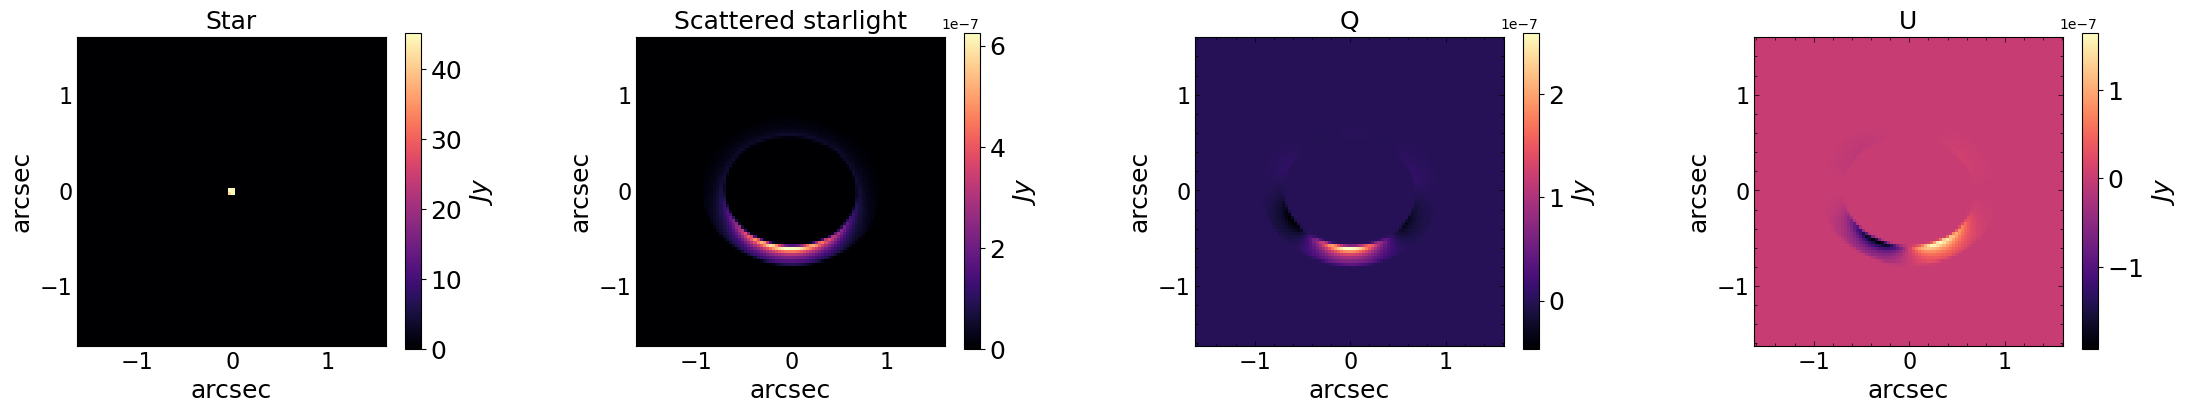

In [101]:
bandavg(f_dir)

In [102]:
px=py=256
psf_scale=0.02182 ##arcsecs/pixel
xpix=(np.arange ((-px/2)+96, (px/2)-96, 1))*psf_scale
ypix=(np.arange ((-px/2)+96, (px/2)-96, 1))*psf_scale
sq_as_per_pix=psf_scale**2

sst=fits.getdata(f_dir+'sst_band.fits')
Q=fits.getdata(f_dir+'Q_band.fits')
U=fits.getdata(f_dir+'U_band.fits')
nx=128-32
ny=128+32

In [103]:
X, Y = np.mgrid[(0):(256):256j, (0):(256):256j]
Phi=np.arctan2((X-128),(Y-128))

Q_phi=-Q*np.cos(2*Phi)-U*np.sin(2*Phi)
U_phi=-Q*np.sin(2*Phi)+U*np.cos(2*Phi)
theta=0.5*np.arctan2(U,Q)
theta[np.isnan(theta)]=0
p=Q_phi/sst
p[np.isnan(p)]=0

/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_34910/2990813452.py:8: RuntimeWarning: invalid value encountered in true_divide
  p=Q_phi/sst


In [69]:
np.max(theta)

1.5707963267948966

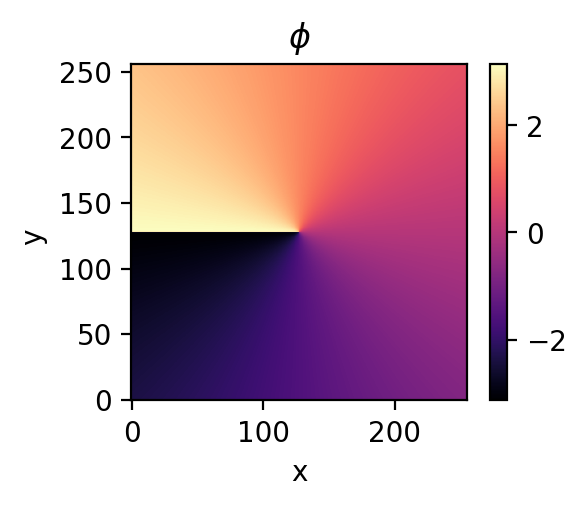

In [104]:
fig = plt.figure(dpi=200)
ax1=fig.add_subplot(221)
im1=ax1.imshow(Phi.astype(np.float64),cmap='magma')
ax1.invert_yaxis()
ax1.set_ylabel('y ')
ax1.set_xlabel('x')
ax1.set_title(r'$\phi$')
cb = fig.colorbar(im1,orientation='vertical')
ax1.grid(False)

In [105]:
figure_dir='/Users/polaris/Onedrive-UA/OneDrive - University of Arizona/Debris-Disk-Modelling/Debris-Disk-Modelling/Eps-eri-Roman_pol/Simulations_paper/Revision/Figures/'

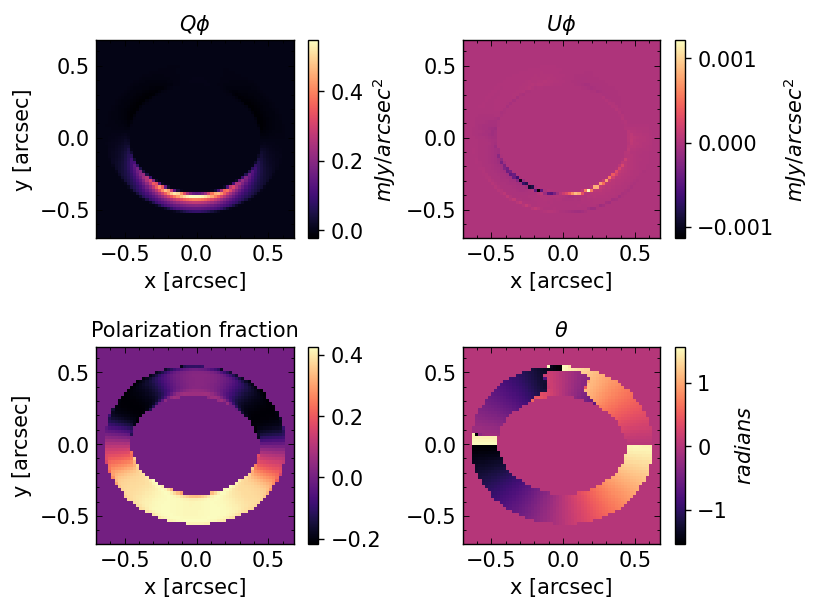

In [106]:
fig = plt.figure(dpi=125)
ax1=fig.add_subplot(221)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', width=0.5,labelsize=12)
im1=ax1.imshow(Q_phi.astype(np.float64)[nx:ny,nx:ny]/sq_as_per_pix*1000,cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax1.invert_yaxis()
ax1.set_ylabel('y [arcsec]',fontsize=12)
ax1.set_xlabel('x [arcsec]',fontsize=12)
ax1.set_title(r'$Q\phi$',fontsize=12)
cb = fig.colorbar(im1,orientation='vertical')
cb.ax.tick_params(labelsize=12)
cb.set_label("$mJy/arcsec^2$",fontsize=12)


ax2=fig.add_subplot(222)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', width=0.5,labelsize=12)
im2=ax2.imshow(U_phi.astype(np.float64)[nx:ny,nx:ny]/sq_as_per_pix*1000,cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax2.invert_yaxis()
#ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]',fontsize=12)
ax2.set_title(r'$U\phi$',fontsize=12)
cb = fig.colorbar(im2,orientation='vertical')
cb.ax.tick_params(labelsize=12)
cb.set_label("$mJy/arcsec^2$",fontsize=12)



ax1=fig.add_subplot(223)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', width=0.5,labelsize=12)
im1=ax1.imshow(p.astype(np.float64)[nx:ny,nx:ny],cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax1.invert_yaxis()
ax1.set_ylabel('y [arcsec]',fontsize=12)
ax1.set_xlabel('x [arcsec]',fontsize=12)
ax1.set_title('Polarization fraction',fontsize=12)
cb = fig.colorbar(im1,orientation='vertical')
cb.ax.tick_params(labelsize=12)
#cb.set_label("$p$",fontsize=12)


ax1=fig.add_subplot(224)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', width=0.5,labelsize=12)
im1=ax1.imshow(theta.astype(np.float64)[nx:ny,nx:ny],cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax1.invert_yaxis()
#ax1.set_ylabel('y [arcsec]')
ax1.set_xlabel('x [arcsec]',fontsize=12)
ax1.set_title(r'$\theta$',fontsize=12)
cb = fig.colorbar(im1,orientation='vertical')
cb.ax.tick_params(labelsize=12)
cb.set_label("$radians$",fontsize=12)

fig.subplots_adjust(hspace=0.55, wspace=0.25, top=0.95, right=0.95)
#fig.savefig(figure_dir+'Stokes_azimuth_epseri_carbon.pdf', format='pdf',bbox_inches='tight')

In [107]:
y, x = np.indices(Q_phi.shape)     # 0.0665AU/pixel
center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
qx, qy=np.unravel_index(np.argmax(Q_phi), Q_phi.shape)
prx, pry =np.unravel_index(np.argmax(p), p.shape)
        
npix=2
        
Q_flux_lin=Q_phi[qx-npix:qx+1,qy-npix:qy+1]
p_r_lin   =p[prx-npix:prx+1,pry-npix:pry+1]

Q_flux_err=np.std(Q_flux_lin)
p_r_err  =np.std(p_r_lin)

In [108]:
prx, pry =np.unravel_index(np.argmax(p), p.shape)
prx,pry

(116, 114)

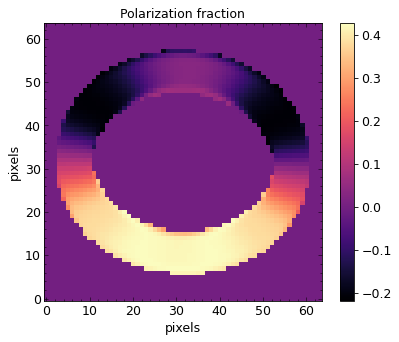

In [109]:
p_new=p[96:160,96:160]

fig = plt.figure(dpi=75)
ax1=fig.add_subplot(111)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', width=0.5,labelsize=12)
im1=ax1.imshow(p_new,cmap='magma')
ax1.invert_yaxis()
ax1.set_ylabel('pixels',fontsize=12)
ax1.set_xlabel('pixels',fontsize=12)
ax1.set_title('Polarization fraction',fontsize=12)
cb = fig.colorbar(im1,orientation='vertical')
cb.ax.tick_params(labelsize=12)

In [86]:
prx, pry =np.unravel_index(np.argmax(p_new), p.shape)
prx,pry

(5, 18)

In [342]:
np.max(Q_phi.astype(np.float64)[nx:ny,nx:ny]/sq_as_per_pix*1000)

0.5458496428275983

In [317]:
np.max(Q_phi)

2.598857834857906e-07

In [116]:
#Roman IPAC estimations
# reference and target star from Os9
# ζ Pup V=2.25 
m_z=2.25
ph_z=9.39854e+08  #ph/s

#47 UMa, V=5.04
m_u=5.04
ph_u=8.24037e+07


# conversion to flux in Jy
F_z=3631*10**(m_z*(-0.4))
F_u=3631*10**(m_u*(-0.4))

# surface brightness of epsilon eridani calculation in mag/sqarcsec, sst is the scattered light 
# from MCFOST converted to Jy
SB=-2.5*np.log10(sst.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z

#convert the SB to photons/second
Nphot=ph_z*10**(-0.4*(SB-m_z)) #SB is in mag/arc^2

/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_34910/3323264297.py:2: RuntimeWarning: divide by zero encountered in log10
  SB=-2.5*np.log10(sst.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z


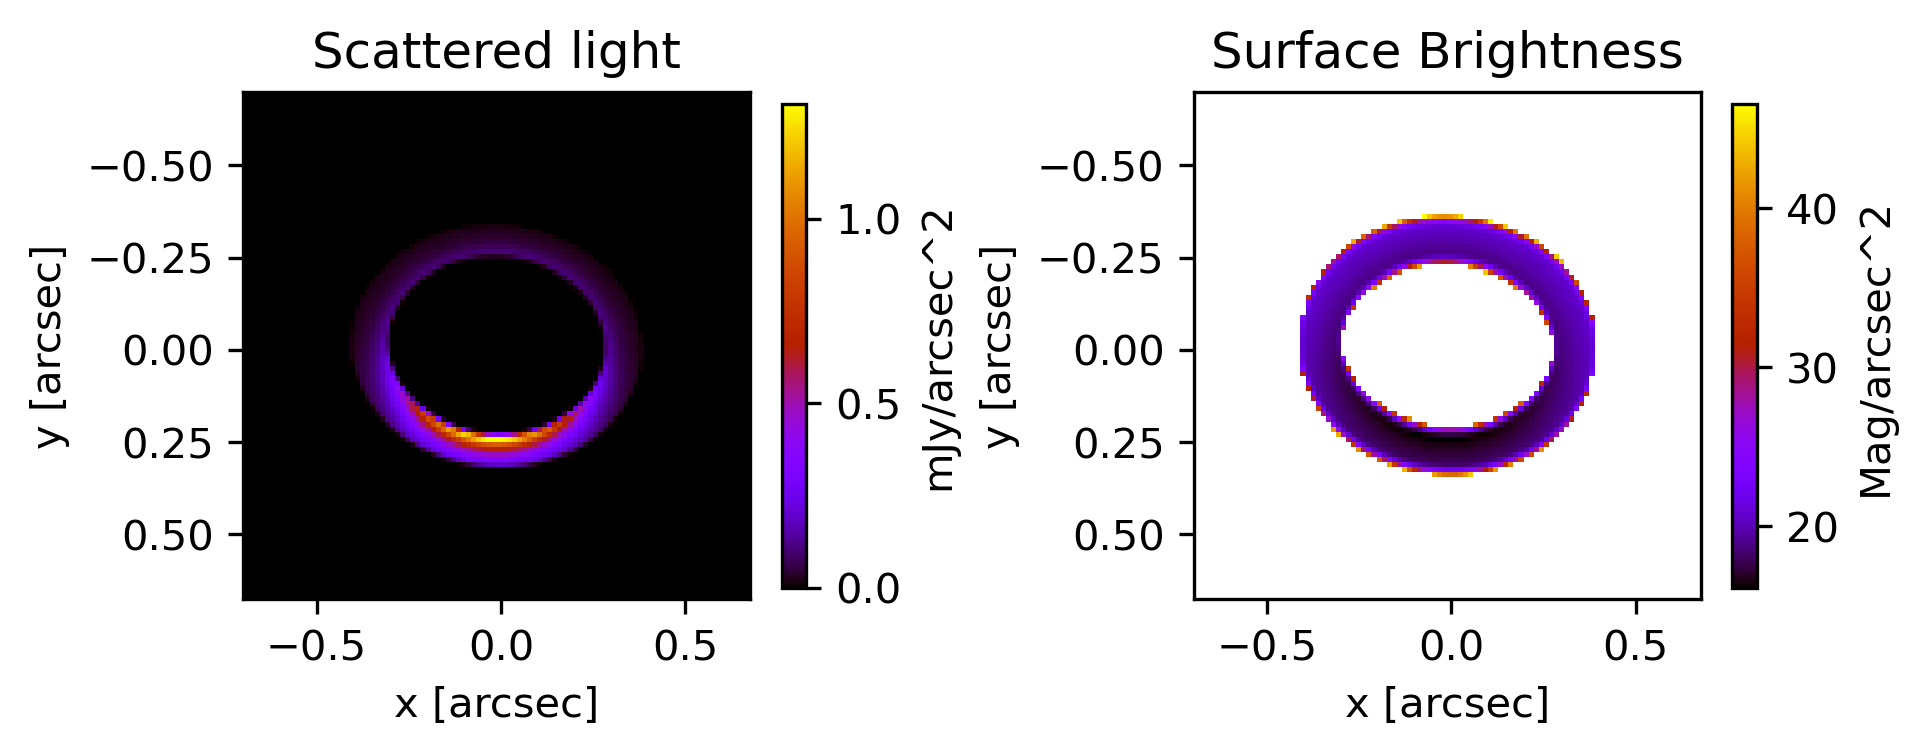

In [118]:
fig=plt.figure(dpi=300)
ax2=plt.subplot(121)
im2=ax2.imshow(sst.astype(np.float64)[78:178,78:178]/sq_as_per_pix*1000,
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('Scattered light')
cb=plt.colorbar(im2,orientation='vertical',shrink=0.4)
cb.set_label("mJy/arcsec^2")

ax2=plt.subplot(122)
im2=ax2.imshow(SB.astype(np.float64)[78:178,78:178],
               cmap='gnuplot',extent=[np.min(ypix),np.max(ypix),np.min(xpix),np.max(xpix)])
ax2.invert_yaxis()
ax2.set_ylabel('y [arcsec]')
ax2.set_xlabel('x [arcsec]')
ax2.set_title('Surface Brightness')
cb=plt.colorbar(im2,orientation='vertical',shrink=0.4)
cb.set_label("Mag/arcsec^2")
fig.subplots_adjust(hspace=0.65, wspace=0.5, top=0.95, right=0.95)

In [121]:
Nphot=ph_z*10**(-0.4*(SB-m_z)) #sst_mag is in mag/arc^2

In [122]:
np.max(Nphot)

2696.1526675370146

In [123]:
I0=(sst+Q)/2
I90=(sst-Q)/2
I45=(sst+U)/2
I135=(sst-U)/2

In [93]:
I0sb=-2.5*np.log10(I0.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
I0ph=ph_z*10**(-0.4*(I0sb-m_z))

I90sb=-2.5*np.log10(I90.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
I90ph=ph_z*10**(-0.4*(I90sb-m_z))

I45sb=-2.5*np.log10(I45.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
I45ph=ph_z*10**(-0.4*(I45sb-m_z))

I135sb=-2.5*np.log10(I135.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
I135ph=ph_z*10**(-0.4*(I135sb-m_z))

/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_34910/1463891641.py:1: RuntimeWarning: divide by zero encountered in log10
  I0sb=-2.5*np.log10(I0.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_34910/1463891641.py:4: RuntimeWarning: divide by zero encountered in log10
  I90sb=-2.5*np.log10(I90.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_34910/1463891641.py:7: RuntimeWarning: divide by zero encountered in log10
  I45sb=-2.5*np.log10(I45.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z
/var/folders/tz/b2jsht6d7nv7db1v7bt3645c0000gn/T/ipykernel_34910/1463891641.py:10: RuntimeWarning: divide by zero encountered in log10
  I135sb=-2.5*np.log10(I135.astype(np.float64)/F_z)+2.5*np.log10(sq_as_per_pix)+m_z


In [115]:
#N0=Nphot*(1+p*np.cos(2*theta))/2
#N1=Nphot*(1-p*np.cos(2*theta))/2
#N2=Nphot*(1+p*np.sin(2*theta))/2
#N3=Nphot*(1-p*np.sin(2*theta))/2

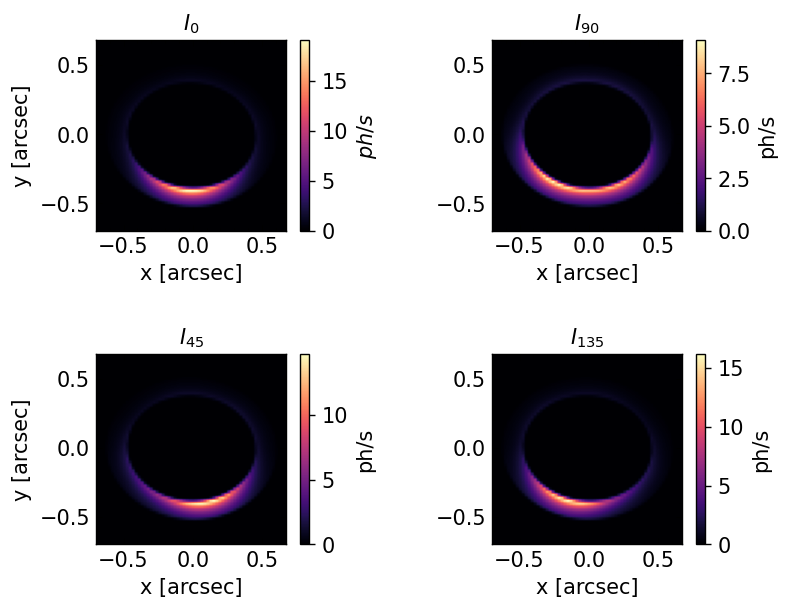

In [97]:
fig = plt.figure(dpi=125)
ax1=fig.add_subplot(221)
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.minorticks_on()
ax1.tick_params(which='both', direction='in', width=0.5,labelsize=12)
im1=ax1.imshow(I0ph[nx:ny,nx:ny],cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax1.invert_yaxis()
ax1.set_ylabel('y [arcsec]',fontsize=12)
ax1.set_xlabel('x [arcsec]',fontsize=12)
ax1.set_title('$I_{0}$',fontsize=12)
cb = fig.colorbar(im1,orientation='vertical')
cb.ax.tick_params(labelsize=12)
cb.set_label("$ph/s$",fontsize=12)


ax2=fig.add_subplot(222)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.minorticks_on()
ax2.tick_params(which='both', direction='in', width=0.5,labelsize=12)
im2=ax2.imshow(I90ph[nx:ny,nx:ny],cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax2.invert_yaxis()
#ax2.set_ylabel('y [arcsec]',fontsize=12)
ax2.set_xlabel('x [arcsec]',fontsize=12)
ax2.set_title('$I_{90}$',fontsize=12)
cb = fig.colorbar(im2,orientation='vertical')
cb.ax.tick_params(labelsize=12)
cb.set_label("ph/s",fontsize=12)


ax3=fig.add_subplot(223)
ax3.yaxis.set_ticks_position('both')
ax3.xaxis.set_ticks_position('both')
ax3.minorticks_on()
ax3.tick_params(which='both', direction='in', width=0.5,labelsize=12)
im3=ax3.imshow(I45ph[nx:ny,nx:ny],cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax3.invert_yaxis()
ax3.set_ylabel('y [arcsec]',fontsize=12)
ax3.set_xlabel('x [arcsec]',fontsize=12)
ax3.set_title('$I_{45}$',fontsize=12)
cb = fig.colorbar(im3,orientation='vertical')
cb.ax.tick_params(labelsize=12)
cb.set_label("ph/s",fontsize=12)

ax4=fig.add_subplot(224)
ax4.yaxis.set_ticks_position('both')
ax4.xaxis.set_ticks_position('both')
ax4.minorticks_on()
ax4.tick_params(which='both', direction='in', width=0.5,labelsize=12)
im4=ax4.imshow(I135ph[nx:ny,nx:ny],cmap='magma',extent=[np.min(xpix),np.max(xpix),np.max(ypix),np.min(ypix)])
ax4.invert_yaxis()
#ax4.set_ylabel('y [arcsec]',fontsize=12)
ax4.set_xlabel('x [arcsec]',fontsize=12)
ax4.set_title('$I_{135}$',fontsize=12)
cb = fig.colorbar(im4,orientation='vertical')
cb.ax.tick_params(labelsize=12)
cb.set_label("ph/s",fontsize=12)

fig.subplots_adjust(hspace=0.65, wspace=0.5, top=0.95, right=0.95)
#fig.savefig(figure_dir+'photons_pol_epseri.pdf', format='pdf', bbox_inches='tight')

In [95]:
#I0ph=I0ph/100
#I90ph=I90ph/100
#I45ph=I45ph/100
#I135ph=I135ph/100

In [96]:
hdu = fits.PrimaryHDU(I0ph)
hdul = fits.HDUList([hdu])
hdul.writeto(f_dir+'I_0_hlc.fits',overwrite=True)
hdu = fits.PrimaryHDU(I90ph)
hdul = fits.HDUList([hdu])
hdul.writeto(f_dir+'I_90_hlc.fits',overwrite=True)
hdu = fits.PrimaryHDU(I45ph)
hdul = fits.HDUList([hdu])
hdul.writeto(f_dir+'I_45_hlc.fits',overwrite=True)
hdu = fits.PrimaryHDU(I135ph)
hdul = fits.HDUList([hdu])
hdul.writeto(f_dir+'I_135_hlc.fits',overwrite=True)